In [9]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import haversine as hs
from haversine import haversine, Unit
import random
import string
from datetime import datetime
from hurricaneModels import HurricaneModel
import xgboost as xgb
from sklearn import svm

## Pre-Processing

In [10]:
# Importing Data
data_folder = glob.glob('matToPyData/*.csv')
data_folder.sort()
data_list = []

for file in data_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    df.drop(df.columns[3], inplace = True, axis = 1) # dropping fake numeric date
    data_list.append(df)



matToPyData/bestStormData_1.csv
matToPyData/bestStormData_2.csv
matToPyData/bestStormData_3.csv
matToPyData/bestStormData_4.csv
matToPyData/bestStormData_5.csv
matToPyData/bestStormData_6.csv
matToPyData/bestStormData_7.csv


In [11]:
# Importing Data Dates
dates_folder = glob.glob('matToPyDates/*.csv')
dates_folder.sort()
dates_list = []

for file in dates_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    dates_list.append(df)

matToPyDates/bestStormDates_1.csv
matToPyDates/bestStormDates_2.csv
matToPyDates/bestStormDates_3.csv
matToPyDates/bestStormDates_4.csv
matToPyDates/bestStormDates_5.csv
matToPyDates/bestStormDates_6.csv
matToPyDates/bestStormDates_7.csv


### Feature Engineering

In [12]:
random.seed(10)
final_data_list = []
for i in range(0, len(dates_list)):
    df = pd.concat([data_list[i], dates_list[i]], axis = 1)
    df.columns = ['lat', 'long', 'distance', 'azimuth', 'speed', 'cp', 'windspeed', 
                  'landfall_flag', 'overland_flag', 'maxwind', 'min_cp','rad_maxwind', 'eye_diam', 'pressure_isobar', 'rad_isobar' ,'date_time']
    #print(df.shape)
    
    df = df[df['lat'].between(-90,90)] # removing impossible long lat values
    df = df[df['long'].between(-180,180)]
    
    #print(df.shape)

    df['SID'] = random.choice(string.ascii_uppercase) + '_' + str(i + 1) #assigning IDs

    df['date_time'] = pd.to_datetime(df['date_time']) # converting dates to timedate
    final_data_list.append(df)

In [13]:
def haversine(lat1, lat2, lon1, lon2):
    p1 = (lat1, lon1)
    p2 = (lat2, lon2)
    return hs.haversine(p1, p2)

# Adding between point distance as a feature
for data in final_data_list:
    data.loc[0, 'derived_distance'] = 0
    for i in range(1, len(data)):
        data.loc[i, 'derived_distance'] = haversine(data.iloc[i-1, :]['lat'], 
                                                     data.iloc[i, :]['lat'], 
                                                     data.iloc[i-1, :]['long'], 
                                                     data.iloc[i, :]['long'])

In [14]:
# Exporting all final preprocessed data:
k = 1
for data in final_data_list:
    data.to_csv('/Users/jasonluo/Documents/Hurricane_proj/finalPreprocData/final_dataset' + str(k) + '.csv', 
                index = False)
    k += 1

## Analysis

['S_1'] MSE: 430.1343277657377 MAE: 14.750371612637537 MAPE: 15.792521745365514


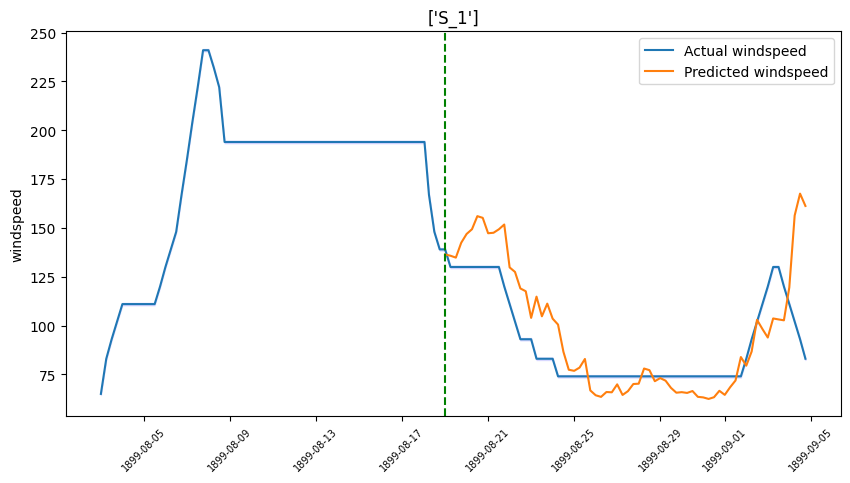

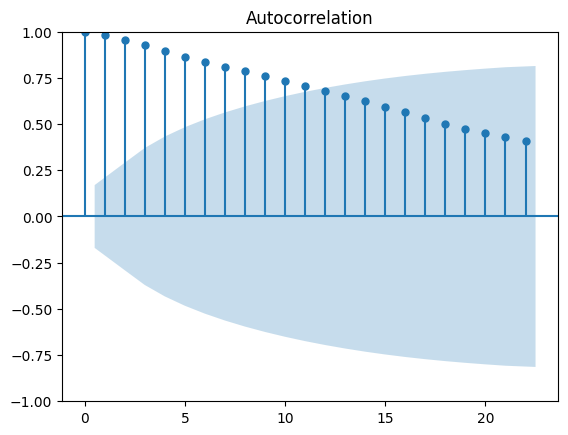

['B_2'] MSE: 828.0934893957808 MAE: 24.0656118148544 MAPE: 18.438405228199148


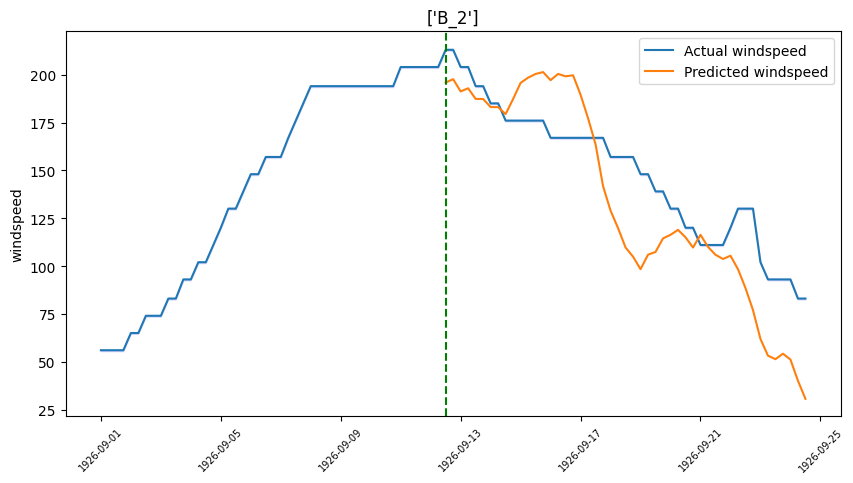

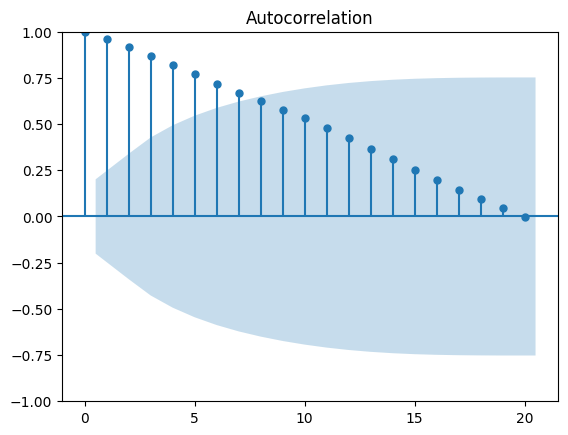

['N_3'] MSE: 2813.208996286093 MAE: 41.06002311772326 MAPE: 38.74625387549818


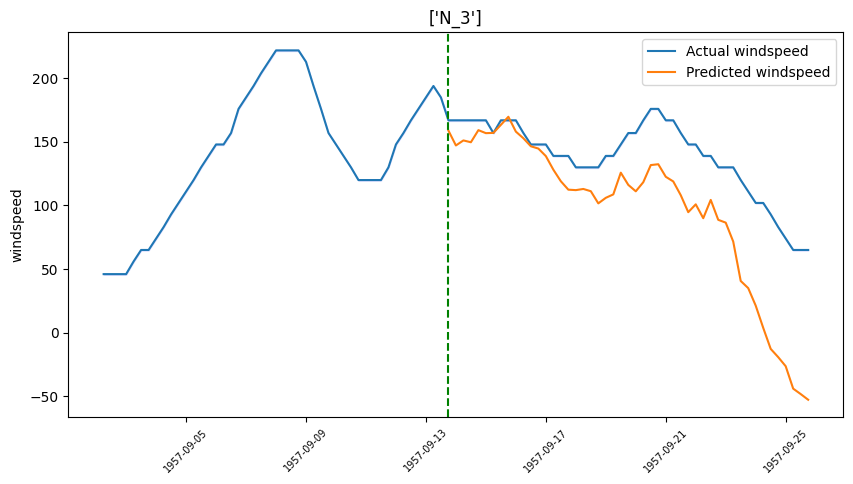

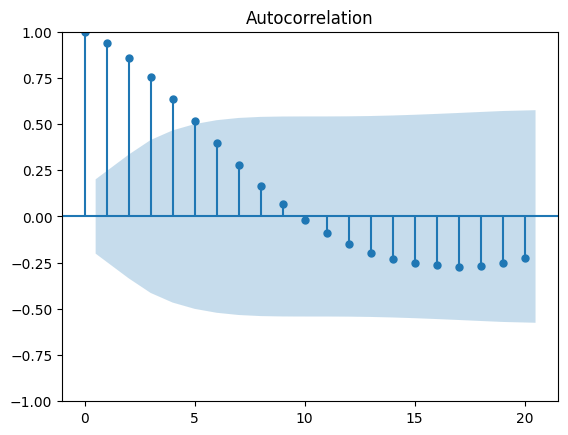

['P_4'] MSE: 1258.9241229261206 MAE: 24.264338077876527 MAPE: 16.59409775841947


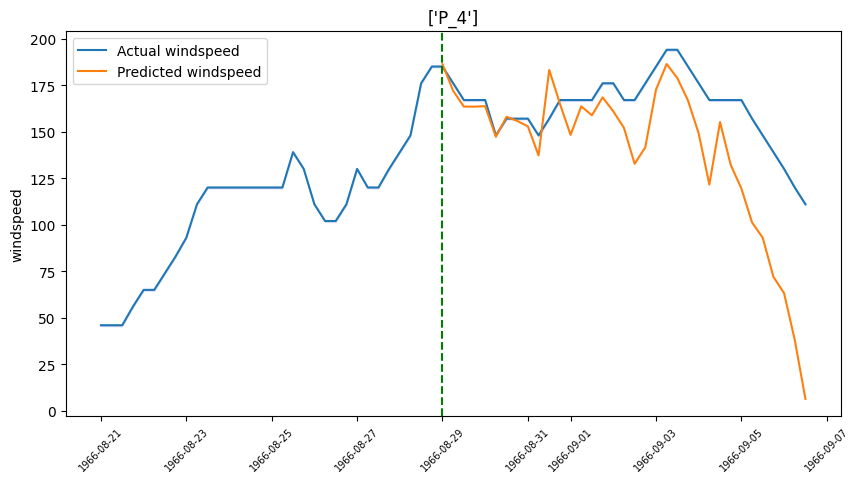

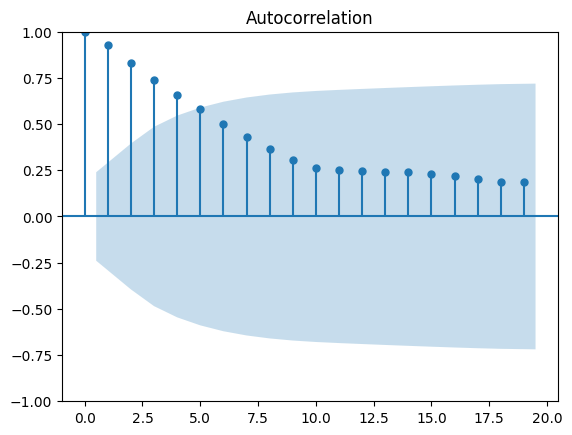

['S_5'] MSE: 115.49096245519124 MAE: 9.316557800366983 MAPE: 10.52037859281458


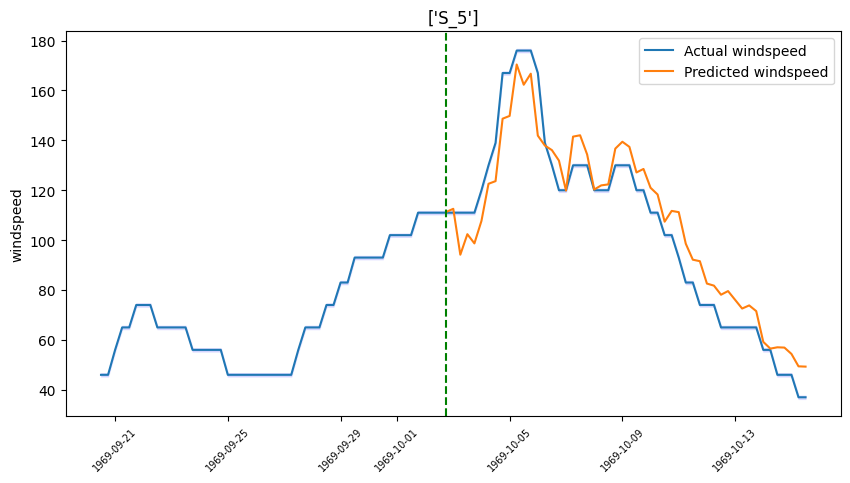

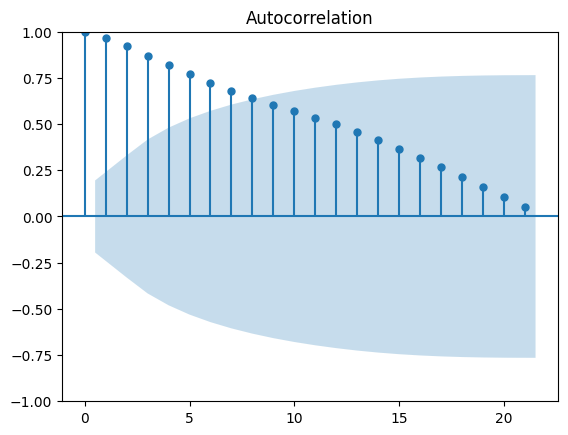

['A_6'] MSE: 627.1427976730582 MAE: 21.341753602890034 MAPE: 23.230281416673634


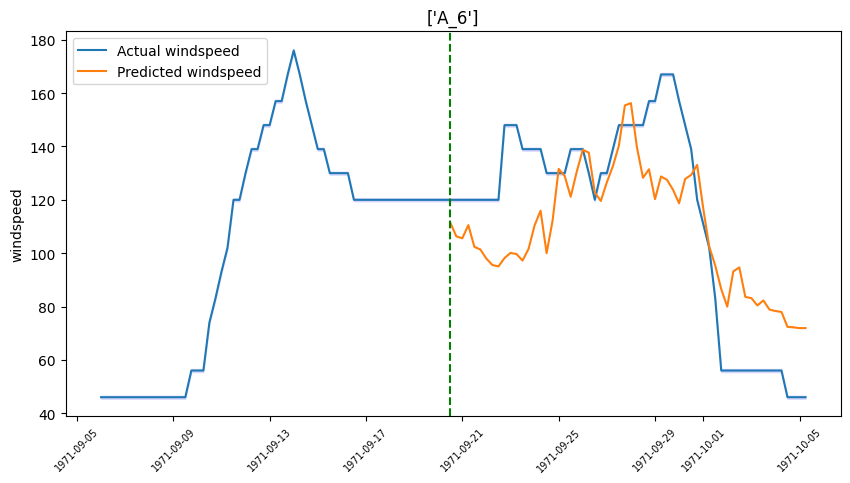

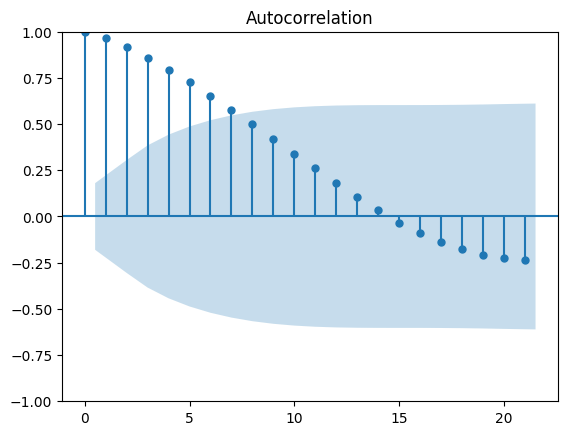

['G_7'] MSE: 275.4847130291732 MAE: 14.691859816665012 MAPE: 14.184408514274075


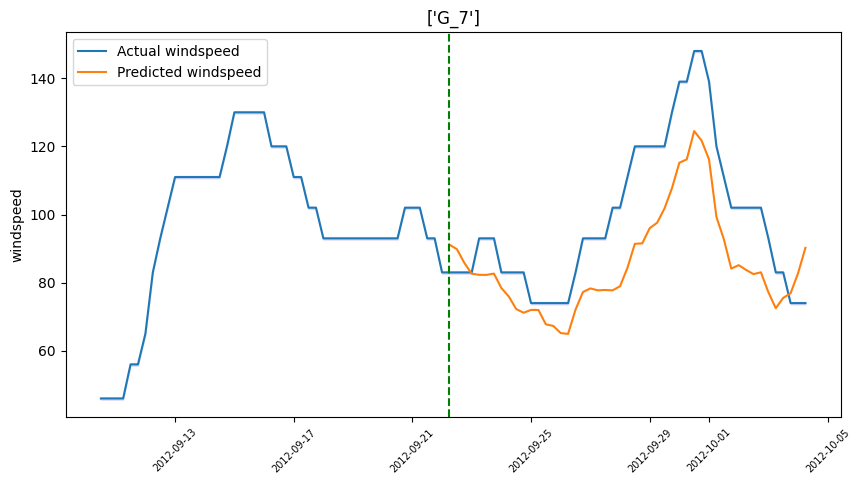

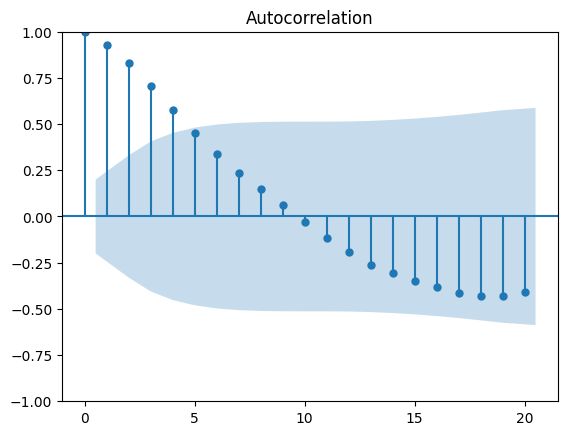

In [17]:
feats = ['lat', 'long', 'speed', 'cp', 'derived_distance']
target = 'windspeed'
ratio = 0.5

model1 = xgb.XGBRegressor(n_estimators = 100)
model2 = svm.SVR(kernel = 'linear')

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.split_train_predict(ratio, feats, target, True)
    Hmodel.plotACF(target)

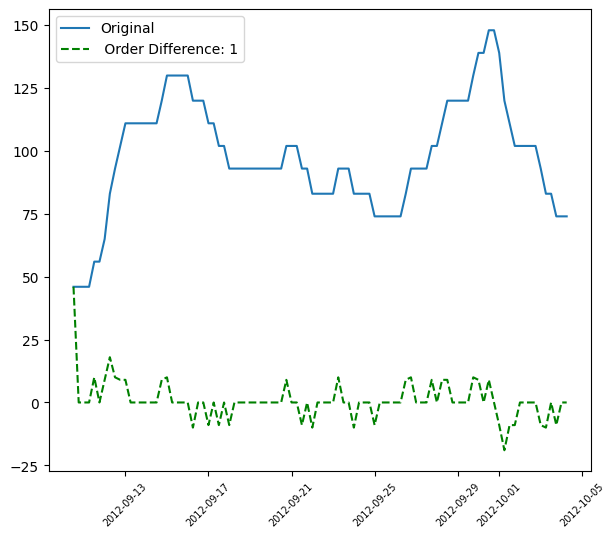

In [16]:
diffed_data = Hmodel.plotDiff('windspeed', order = 1)